In [1]:
import mat73
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
# Load in dataset
eeg = mat73.loadmat("Data/s01.mat")

# Preprocessing

In [3]:
# copied from original paper code (Link: https://github.com/Kyungho-Won/EEG-dataset-for-RSVP-P300-speller/blob/main/Python/Load_Won2021dataset.ipynb)

# filtering
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, lowcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  b, a = butter(order, low, btype='low')
  y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
  return y

def butter_highpass_filter(data, highcut, fs, order):
  nyq = fs/2
  high = highcut/nyq
  b, a = butter(order, high, btype='high')
  y = filtfilt(b, a, data) # zero-phase filter
  return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
  nyq = fs/2
  low = lowcut/nyq
  high = highcut/nyq
  b, a = butter(order, [low, high], btype='band')
  # demean before filtering
  meandat = np.mean(data, axis=1)
  data = data - meandat[:, np.newaxis]
  y = filtfilt(b, a, data)
  return y

In [4]:
# copied from original paper code (Link: https://github.com/Kyungho-Won/EEG-dataset-for-RSVP-P300-speller/blob/main/Python/Load_Won2021dataset.ipynb)

def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
  # extract epoch from 2D data into 3D [ch x time x trial]
  # input: event, baseline, frame
  # extract epoch = baseline[0] to frame[2]

  # for memory pre-allocation
  if opt_keep_baseline == True:
    begin_tmp = int(np.floor(baseline[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
  else:
    begin_tmp = int(np.floor(frame[0]/1000*srate))
    end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)
  
  epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
  nth_event = 0

  for i in event:
    if opt_keep_baseline == True:
      begin_id = int(i + np.floor(baseline[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))
    else:
      begin_id = int(i + np.floor(frame[0]/1000 * srate))
      end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))
    
    tmp_data = data[:, begin_id:end_id]

    begin_base = int(np.floor(baseline[0]/1000 * srate))
    end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
    base = np.mean(tmp_data[:, begin_base:end_base], axis=1)

    rmbase_data = tmp_data - base[:, np.newaxis]
    epoch3D[:, :, nth_event] = rmbase_data
    nth_event = nth_event + 1

  return epoch3D

In [5]:
# copied from original paper code (Link: https://github.com/Kyungho-Won/EEG-dataset-for-RSVP-P300-speller/blob/main/Python/Load_Won2021dataset.ipynb)

def extractSession(eeg, type, sess_num, baseline, frame, opt_keep_baseline=False):
    # extract session of data organized into epochs [ch x time x trial]
    # input: eeg = eeg data
    #       type = 'train' or 'test'
    #       sess_num = 0-1 for 'train', 0-3 for 'test'
    #       baseline = baseline window in ms
    #       frame = frame window in ms
    # output: target EEG data, nontarget EEG data

    # get the data
    data = np.asarray(eeg[type][sess_num]['data'])

    # only keep relevant electrodes - similar to used in https://ieeexplore.ieee.org/document/7318721
    # elec_to_keep = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
    # based on visual inspection:
    elec_to_keep = ['FP1', 'FP2', 'F3', 'FZ', 'F4', 'T7', 'Cz', 'T8', 'P7', 'P8', 'O1', 'Oz', 'O2']
    idx_to_keep = []
    elec = eeg[type][sess_num]['chanlocs']
    for i in range(len(elec)):
        if elec[i]['labels'] in elec_to_keep:
            idx_to_keep.append(i)
    data = data[idx_to_keep]
    
    # BP filter data from 1-20 Hz using Butterworth filter 
    srate = eeg[type][sess_num]['srate']
    data = butter_bandpass_filter(data, 1, 20, srate, 5) # matching filter from https://arxiv.org/abs/1409.0107
    markers = eeg[type][sess_num]['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, opt_keep_baseline)
    nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, opt_keep_baseline)
    
    return targetEEG, nontargetEEG

In [6]:
# copied from original paper code (Link: https://github.com/Kyungho-Won/EEG-dataset-for-RSVP-P300-speller/blob/main/Python/Load_Won2021dataset.ipynb)

def extractAllSessions(eeg, type, baseline, frame, opt_keep_baseline=False):
    # extract all data session trials and concatanates them [ch x time x trial]
    # input: eeg = eeg data
    #       type = 'train' or 'test'
    #       sess_num = 0-1 for 'train', 0-3 for 'test'
    #       baseline = baseline window in ms
    #       frame = frame window in ms
    # output: all target EEG data, all nontarget EEG data

    for n_sess in range(len(eeg[type])):
        tmp_targetEEG, tmp_nontargetEEG = extractSession(eeg, type, n_sess, baseline, frame, opt_keep_baseline)

    if n_sess == 0:
        all_targetEEG = tmp_targetEEG
        all_nontargetEEG = tmp_nontargetEEG
    else:
        all_targetEEG = np.dstack((all_targetEEG, tmp_targetEEG))
        all_nontargetEEG = np.dstack((all_nontargetEEG, tmp_nontargetEEG))

    return all_targetEEG, all_nontargetEEG

In [7]:
# Parameters
baseline = [-200, 0] # in ms
frame = [0, 1000] # in ms

train_session_target_data = []
test_session_target_data = []
train_session_nontarget_data = []
test_session_nontarget_data = []

for n_train in range(len(eeg['train'])):
    target_data, nontarget_data = extractSession(eeg, 'train', n_train, baseline, frame, opt_keep_baseline=True)
    train_session_target_data.append(target_data)
    train_session_nontarget_data.append(nontarget_data)

train_session_target_data = np.array(train_session_target_data)
train_session_nontarget_data = np.array(train_session_nontarget_data)

for n_test in range(len(eeg['test'])):
    target_data, nontarget_data = extractSession(eeg, 'test', n_test, baseline, frame, opt_keep_baseline=True)
    test_session_target_data.append(target_data)
    test_session_nontarget_data.append(nontarget_data)

test_session_target_data = np.array(test_session_target_data)
test_session_nontarget_data = np.array(test_session_nontarget_data)

C:\Users\hanna\AppData\Local\Temp\ipykernel_33504\164210648.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)


# Plot ERP

In [8]:
# elec_to_keep = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']
elec_to_keep = ['FP1', 'FP2', 'F3', 'FZ', 'F4', 'T7', 'Cz', 'T8', 'P7', 'P8', 'O1', 'Oz', 'O2']
elec_ordered = []
elec = eeg['train'][0]['chanlocs']
for i in range(len(elec)):
    if elec[i]['labels'] in elec_to_keep:
        elec_ordered.append(elec[i]['labels'])

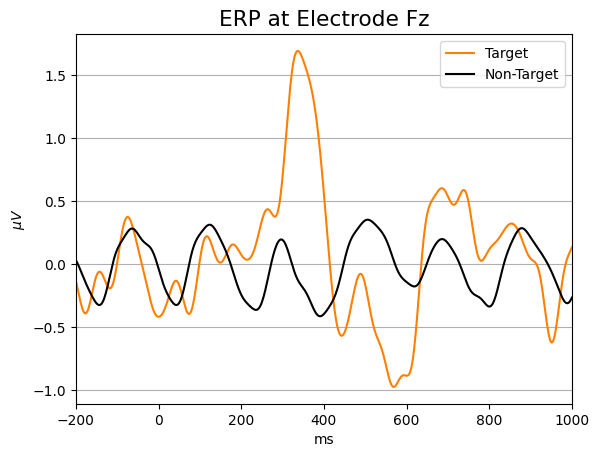

In [9]:
avg_target = np.mean(test_session_target_data[0], axis=2)
avg_nontarget = np.mean(test_session_nontarget_data[0], axis=2)

# averaged target & nontarget ERPs - visualization
# plotting code based on: https://github.com/Kyungho-Won/EEG-dataset-for-RSVP-P300-speller/blob/main/Python/Load_Won2021dataset.ipynb
elec_to_vis = 'FZ'
t = np.linspace(-200, 1000, avg_target.shape[1])
plt.plot(t, avg_target[elec_ordered.index(elec_to_vis), :].transpose(), color=[1, 0.5, 0], label="Target")
plt.plot(t, avg_nontarget[elec_ordered.index(elec_to_vis), :].transpose(), color=[0, 0, 0], label="Non-Target")
plt.legend()
plt.xlabel('ms')
plt.ylabel(r'$\mu V$')
plt.gca().yaxis.grid(True)
plt.rcParams.update({'font.size': 13})
plt.xlim([-200, 1000])
plt.gca().pbasepect = np.array([2, 1, 1])
plt.title("ERP at Electrode Fz")
plt.savefig("ERP_vis_FZ.png")
plt.show()

# Prepare Covariance Matrices

In [10]:
# Parameters - with data considered
# window from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4106671/
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

train_session_target_data = []
test_session_target_data = []
train_session_nontarget_data = []
test_session_nontarget_data = []

for n_train in range(len(eeg['train'])):
    target_data, nontarget_data = extractSession(eeg, 'train', n_train, baseline, frame, opt_keep_baseline=False)
    train_session_target_data.append(target_data)
    train_session_nontarget_data.append(nontarget_data)

train_session_target_data = np.array(train_session_target_data)
train_session_nontarget_data = np.array(train_session_nontarget_data)

for n_test in range(len(eeg['test'])):
    target_data, nontarget_data = extractSession(eeg, 'test', n_test, baseline, frame, opt_keep_baseline=False)
    test_session_target_data.append(target_data)
    test_session_nontarget_data.append(nontarget_data)

test_session_target_data = np.array(test_session_target_data)
test_session_nontarget_data = np.array(test_session_nontarget_data)

C:\Users\hanna\AppData\Local\Temp\ipykernel_33504\164210648.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)


In [11]:
def normalize_data(data):
    n_elec, n_samp, n_trial = data.shape
    max_over_trial_per_elec = np.max(np.abs(data), axis=1)
    max_over_trial_per_elec = np.tile(max_over_trial_per_elec, (n_samp, 1, 1,))
    max_over_trial_per_elec = np.moveaxis(max_over_trial_per_elec, 0, 1)

    return data / max_over_trial_per_elec

In [12]:
# adapted from this paper: https://ieeexplore.ieee.org/document/8013808, https://arxiv.org/abs/1409.0107 

def prepare_covmat(sess_data_target, sess_data_nontarget):
    # prepares the covariance matrices that are used as features for classification
    # input: sess_data_target, sess_data_nontarget (output of extractSession function)
    # output: all target covariance matrices, all nontarget covariance matrices
    
    n_elec, n_samp, n_trial_target = sess_data_target.shape
    n_elec, n_samp, n_trial_nontarget = sess_data_nontarget.shape
    n_trial = n_trial_target + n_trial_nontarget

    # normalize the data
    target_data = sess_data_target.copy()
    target_data = normalize_data(target_data)
    nontarget_data = sess_data_nontarget.copy()
    nontarget_data = normalize_data(nontarget_data)

    # prepare augmented matrices
    E_mat = np.mean(target_data, axis=2)
    E_mat_target = np.tile(E_mat, (n_trial_target, 1, 1))
    E_mat_target = np.moveaxis(E_mat_target, 0, -1)
    aug_data_target = np.vstack([E_mat_target, target_data])

    E_mat_nontarget = np.tile(E_mat, (n_trial_nontarget, 1, 1))
    E_mat_nontarget = np.moveaxis(E_mat_nontarget, 0, -1)
    aug_data_nontarget = np.vstack([E_mat_nontarget, nontarget_data])

    # create augmented covariance matrices
    target_cov = np.asarray([((1 / (n_samp - 1)) * aug_data_target[:,:,i] @ aug_data_target[:,:,i].T) for i in range(n_trial_target)])
    nontarget_cov = np.asarray([((1 / (n_samp - 1)) * aug_data_nontarget[:,:,i] @ aug_data_nontarget[:,:,i].T) for i in range(n_trial_nontarget)])

    return target_cov, nontarget_cov

In [13]:
# for one subject, this takes ~19 seconds to run
train_target_cov = []
train_nontarget_cov = []
test_target_cov = []
test_nontarget_cov = []

for n_train in range(len(eeg['train'])):
    target_cov, nontarget_cov = prepare_covmat(train_session_target_data[n_train], train_session_nontarget_data[n_train])
    train_target_cov.append(target_cov)
    train_nontarget_cov.append(nontarget_cov)

train_target_cov = np.array(train_target_cov)
train_nontarget_cov = np.array(train_nontarget_cov)

for n_test in range(len(eeg['test'])):
    target_cov, nontarget_cov = prepare_covmat(test_session_target_data[n_test], test_session_nontarget_data[n_test])
    test_target_cov.append(target_cov)
    test_nontarget_cov.append(nontarget_cov)

test_target_cov = np.array(test_target_cov)
test_nontarget_cov = np.array(test_nontarget_cov)

In [14]:
from pyriemann.utils.covariance import normalize

train_target_cov = normalize(train_target_cov, "corr")
train_nontarget_cov = normalize(train_nontarget_cov, "corr")
test_target_cov = normalize(test_target_cov, "corr")
test_nontarget_cov = normalize(test_nontarget_cov, "corr")

In [15]:
import seaborn as sns

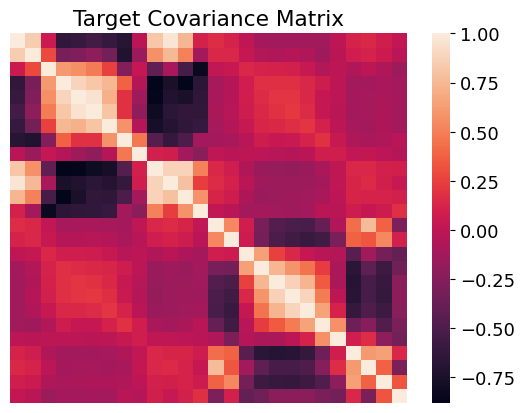

In [16]:
corr_plot = sns.heatmap(np.mean(train_target_cov[0], axis=0))
corr_plot.set_xticks([])
corr_plot.set_yticks([])
corr_plot.set_title("Target Covariance Matrix")

fig = corr_plot.get_figure()
fig.savefig("target_corr_mat.png") 

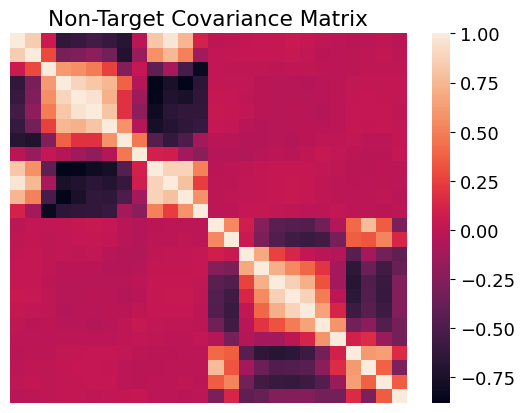

In [17]:
corr_plot = sns.heatmap(np.mean(train_nontarget_cov[0], axis=0))
corr_plot.set_xticks([])
corr_plot.set_yticks([])
corr_plot.set_title("Non-Target Covariance Matrix")

fig = corr_plot.get_figure()
fig.savefig("nontarget_corr_mat.png") 

# Center Metrics

In [18]:
from pyriemann.utils.base import sqrtm, invsqrtm, logm, expm, powm

In [19]:
# definition from https://ieeexplore.ieee.org/document/8013808
def riemannian_distance(X,Y):
    mat_size = int(np.sqrt(len(X)))
    X_mat = np.reshape(X, (mat_size, mat_size))
    Y_mat = np.reshape(Y, (mat_size, mat_size))
    return np.linalg.norm(logm(np.linalg.inv(X_mat) @ Y_mat), ord="fro")

In [20]:
# matches what we expect: https://ieeexplore.ieee.org/document/8013808
def euclidean_mean(P_set):
    return np.mean(P_set, axis=0)

In [722]:
# from: https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/mean.py#L22 
# derived from: https://link.springer.com/chapter/10.1007/978-3-642-00826-9_6 
def grad_riemann_mean(P_set, P_mean, weights):
    P_invsqrt = invsqrtm(P_mean)
    return np.einsum('a,abc->bc', weights, logm(P_invsqrt @ P_set @ P_invsqrt))

# find riemannian mean using gradient descent 
def riemannian_mean(P_set, max_iter=50, nu=1.0, tol=10e-9, weights=None):
    tau = np.finfo(np.float64).max
    crit = np.finfo(np.float64).max

    mean_curr = euclidean_mean(P_set)
    n_trials, n_cov, _ = P_set.shape

    if weights == None:
        weights = np.ones(n_trials) / n_trials # evenly weigh all trials

    for i in range(max_iter):
        mean_sqrt = sqrtm(mean_curr)
        grad = grad_riemann_mean(P_set, mean_curr, weights)
        mean_curr = mean_sqrt @ expm(nu * grad) @ mean_sqrt

        # this is taken directly from the first link
        crit = np.linalg.norm(grad, ord='fro')
        h = nu * crit
        if h < tau:
            nu = 0.95 * nu
            tau = h
        else:
            nu = 0.5 * nu
        if crit <= tol or nu <= tol:
            break

    return mean_curr

In [828]:
# stopping criteria from: https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/mean.py#L22
# from: https://proceedings.neurips.cc/paper/2017/hash/6ef80bb237adf4b6f77d0700e1255907-Abstract.html
# according to the paper, it's supposed to be accelerated - but at least with this implementation, it is slower by an order of magnitude
# speed changes depending on L (not linearly) - out of scope of this project to investigate this further
def momen_riemannian_mean(P_set, max_iter=50, nu=1.0, tol=10e-9, weights=None):
    tau = np.finfo(np.float64).max
    crit = np.finfo(np.float64).max

    x_prev = euclidean_mean(P_set)
    x = euclidean_mean(P_set)
    y = euclidean_mean(P_set)
    n_trials, n_cov, _ = P_set.shape

    mu = 2*n_trials
    L = 2.25*n_trials
    gamma = 1 / (1-np.sqrt(mu/L))
    cons = np.sqrt(1-np.sqrt(mu/L))
    beta = (4 / np.sqrt(mu*L)) - (1/L)

    if weights == None:
        weights = np.ones(n_trials) / n_trials # evenly weigh all trials
    
    for i in range(max_iter):
        grad = grad_riemann_mean(P_set, y, weights)

        # exponential mapping
        y_sqrt = sqrtm(y)
        y_invsqrt = invsqrtm(y)
        x_prev = x
        x = y_sqrt @ expm(nu*grad) @ y_sqrt #y_sqrt @ expm(y_invsqrt @ (-nu * grad) @ y_invsqrt) @ y_sqrt

        # solve for x 
        x_sqrt = sqrtm(x)
        y = x_sqrt @ np.linalg.inv(expm(cons * logm(y_invsqrt @ x_prev @ y_invsqrt) + (gamma*beta)*grad_riemann_mean(P_set, y, weights))) @ x_sqrt

        # this is taken directly from the first link
        crit = np.linalg.norm(grad, ord='fro')
        h = nu * crit
        if h < tau:
            nu = 0.95 * nu
            tau = h
        else:
            nu = 0.5 * nu
        if crit <= tol or nu <= tol:
            break
    
    return x 

In [478]:
# from https://www.sciencedirect.com/science/article/pii/S0377042711005218
# uses ADMM + proximal update to do the update
# old notes:
# note this is pretty sensitive to gamma and lambda - low gamma --> nontarget, high gamma --> target
# may need to optimize over gamma and lambda, note you have to bias towards target in training to get decent performance in testing
# initialization seems to change w
def matrix_median(P_set, lam=0, gamma=1, max_iter=200, tol=10e-9):
    # diff = []
    n_trials, n_cov, _ = P_set.shape

    mat_rn = np.zeros((n_cov, n_cov)) #np.random.randn(n_cov, n_cov)
    mat_rn = mat_rn.T @ mat_rn

    V_curr = np.tile(mat_rn, (n_trials,1,1)) 

    mat_rn = np.zeros((n_cov, n_cov)) # np.random.randn(n_cov, n_cov)
    mat_rn = mat_rn.T @ mat_rn
    B_curr = np.tile(mat_rn, (n_trials,1,1))
    
    mat_rn = np.zeros((n_cov, n_cov)) # np.random.randn(n_cov, n_cov)
    mat_rn = mat_rn.T @ mat_rn
    S_curr = np.tile(mat_rn, (n_trials,1,1))

    X_curr = euclidean_mean(P_set) # informed start
    X_prev = X_curr

    for i in range(max_iter):
        # X update
        X_prev = X_curr
        X_curr = np.linalg.inv((lam*gamma + n_trials)*np.identity(n_cov)) @ (np.sum(V_curr - B_curr, axis=0))

        # termination condition
        if np.linalg.norm(np.abs(X_curr - X_prev), ord='fro') < tol:
            break

        # V update through proximal update on Y
        Y_curr = V_curr - P_set
        S_curr = B_curr + np.tile(X_curr, (n_trials,1,1)) - P_set
        S_norm = np.linalg.norm(S_curr, axis=(1,2), ord='fro')
        Y_new = np.zeros(Y_curr.shape)
        prox_mult = np.tile((1 - (gamma/S_norm)), (n_cov, n_cov, 1))
        prox_mult = np.moveaxis(prox_mult,-1,0)
        greater_idx = S_norm >= gamma
        Y_new[greater_idx] = prox_mult[greater_idx] * S_curr[greater_idx]
        # print(Y_new[~greater_idx])
        Y_curr = Y_new  
        V_curr = Y_curr + P_set # update V_curr

        # B update - dual update
        B_curr = B_curr + np.tile(X_curr, (n_trials,1,1)) - V_curr

        # diff.append(np.linalg.norm(np.abs(X_curr - X_prev), ord='fro'))
        # print("1", np.linalg.norm(np.abs(X_curr), ord='fro'))
        # print("2", np.linalg.norm(np.abs(X_prev), ord='fro'))

    return X_curr #, diff

In [557]:
# See https://www.sciencedirect.com/science/article/pii/S1053811908012019?via%3Dihub 
# uses steepest descent
# directly from: https://github.com/pyRiemann/pyRiemann/blob/master/pyriemann/utils/median.py
def riemannian_median(P_set, nu=1, max_iter=50, tol=10e-9, weights=None):
    n_trials, n_cov, _ = P_set.shape

    curr_med = euclidean_mean(P_set)

    if weights == None:
        weights = np.ones(n_trials) / n_trials # evenly weigh all trials

    for i in range(max_iter):
        distances = np.array([riemannian_distance(P_indiv, curr_med) for P_indiv in P_set])
        is_nonzero = (~(distances == 0))
        nonzero_weights = weights[is_nonzero] / distances[is_nonzero]

        med_sqrt = sqrtm(curr_med)
        med_invsqrt = invsqrtm(curr_med)
        tangent_vecs = logm(med_invsqrt @ P_set[is_nonzero] @ med_invsqrt)
        grad = np.einsum('a,abc->bc', nonzero_weights / np.sum(nonzero_weights), tangent_vecs)
        curr_med = med_sqrt @ expm(nu * grad) @ med_sqrt

        crit = np.linalg.norm(grad, ord='fro')
        if crit <= tol:
            break

    return curr_med

In [ ]:
"""
# from: https://arxiv.org/abs/0911.3474 
def subgrad_riemannian_median(P_set, max_iter=50):
    n_trials, n_cov, _ = P_set.shape

    curr_med = euclidean_mean(P_set)

    for i in range(max_iter):
"""

In [729]:
# From: https://ieeexplore.ieee.org/abstract/document/7523317
def log_map(curr_cent, mat):
    cent_invsqrt = invsqrtm(curr_cent)
    cent_sqrt = sqrtm(curr_cent)
    return cent_sqrt @ logm(cent_invsqrt @ mat @ cent_invsqrt) @ cent_sqrt

def exp_map(curr_cent, mat):
    cent_invsqrt = invsqrtm(curr_cent)
    cent_sqrt = sqrtm(curr_cent)
    return cent_sqrt @ expm(cent_invsqrt @ mat @ cent_invsqrt) @ cent_sqrt

# threshold based outlier (1.5*third quartile)
def huber_grad(P_set, curr_cent):
    n_trials, n_cov, _ = P_set.shape
    dists = riemannian_distance(P_set, curr_cent)
    third_quart = np.quantile(dists, 0.75)
    T = 1.5*third_quart
    idx_outlier = (dists > T)

    dists = np.tile(dists, [n_cov,n_cov,1])
    dists = np.moveaxis(dists,-1,0)

    return (-2/n_trials)*np.sum(log_map(curr_cent, P_set)[~idx_outlier,:], axis=0) - (T/n_trials)*np.sum(log_map(curr_cent, P_set)[idx_outlier,:]/dists[idx_outlier,:], axis=0)

def huber_obj(P_set, curr_cent):
    n_trials, n_cov, _ = P_set.shape
    dists = riemannian_distance(P_set, curr_cent)
    third_quart = np.quantile(dists, 0.75)
    T = 1.5*third_quart
    idx_outlier = (dists > T)

    return (1/n_trials)*np.sum(dists[~idx_outlier]) + (T/n_trials)*np.sum(np.sqrt(dists[idx_outlier]))

def huber_centroid(P_set, alpha=0.25, mu=0.5, nu_init=0.5, max_iter=50, tol=10e-9): 
    n_trials, n_cov, _ = P_set.shape
    curr = euclidean_mean(P_set)
    nu = nu_init

    for i in range(max_iter):
        grad = huber_grad(P_set, curr)

        # attempt at Armijo backsearching - need to check update
        # while huber_obj(P_set, exp_map(curr, -nu*grad)) > (huber_obj(P_set, curr) + nu*np.sum(huber_grad(P_set,curr)*exp_map(curr, -grad))):
        #     nu = mu * nu

        curr = exp_map(curr, -nu*grad)
        crit = np.linalg.norm(grad, ord='fro')
        if crit <= tol:
            break

    return curr

# MDM Classifier

In [602]:
# definition from https://ieeexplore.ieee.org/document/8013808
def riemannian_distance(X,Y):
    X_invsqrtm = invsqrtm(X)
    if X.ndim > 2 or Y.ndim > 2:
        return np.sum(np.log(np.linalg.eigvalsh(X_invsqrtm @ Y @ X_invsqrtm))**2, axis=1)
    else:
        return np.sum(np.log(np.linalg.eigvalsh(X_invsqrtm @ Y @ X_invsqrtm))**2)

In [46]:
# based on riemannian distance
# input is the centers of the two classes and the data to test
# class 0 is nontarget, class 1 is target - shape should be n_trials x n_cov^2 
def mdm_riemann_classifier(center_class0, center_class1, x_test, y_test): 
    n_trials, n_cov, _ = x_test.shape

    pred = []
    for trial_idx in range(n_trials):
        dist_from_0 = riemannian_distance(center_class0, x_test[trial_idx])
        dist_from_1 = riemannian_distance(center_class1, x_test[trial_idx])
    
        if dist_from_0 <= dist_from_1:
            pred.append(0)
        else:
            pred.append(1)
    
    return np.asarray(pred)


In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

def get_confusion_mat(y_pred, y_true, n_nontarget, n_target, if_plot=False):
    true_neg = np.sum((y_pred[:n_nontarget] == 0) & (y_true[:n_nontarget] == 0))
    false_neg = np.sum((y_pred[n_nontarget:] == 0) & (y_true[n_nontarget:] == 1))
    false_pos = np.sum((y_pred[:n_nontarget] == 1) & (y_true[:n_nontarget] == 0))
    true_pos = np.sum((y_pred[n_nontarget:] == 1) & (y_true[n_nontarget:] == 1))

    cf_mat = np.asarray([[true_neg, false_pos], [false_neg, true_pos]])

    if if_plot == True:
        disp = ConfusionMatrixDisplay(cf_mat, display_labels=["Non-target", "Target"])
        disp.plot()
        plt.show()
    
    return cf_mat

In [48]:
def get_stats(cf_mat):
    n_trials = np.sum(cf_mat)
    n_nontarget, n_target = np.sum(cf_mat, axis=1)

    acc = (cf_mat[0,0] + cf_mat[1,1]) / n_trials    # true neg + true pos 
    sens = (cf_mat[1,1]) / n_target                 # tested pos given actually pos
    spec = (cf_mat[0,0]) / n_nontarget              # tested neg given actually neg

    return [acc, sens, spec]

## Riemannian Mean

In [560]:
x_train = np.vstack([train_nontarget_cov[1,:], train_target_cov[1,:]])
y_train = np.hstack([np.zeros(np.size(train_nontarget_cov[1], 0)), np.ones(np.size(train_target_cov[1], 0))])
x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
y_test = np.hstack([np.zeros(np.size(test_nontarget_cov[0], 0)), np.ones(np.size(test_target_cov[0], 0))])

In [50]:
cent0 = riemannian_mean(train_nontarget_cov[1,:])
cent1 = riemannian_mean(train_target_cov[1,:])

res = mdm_riemann_classifier(cent0, cent1, x_train, y_train)

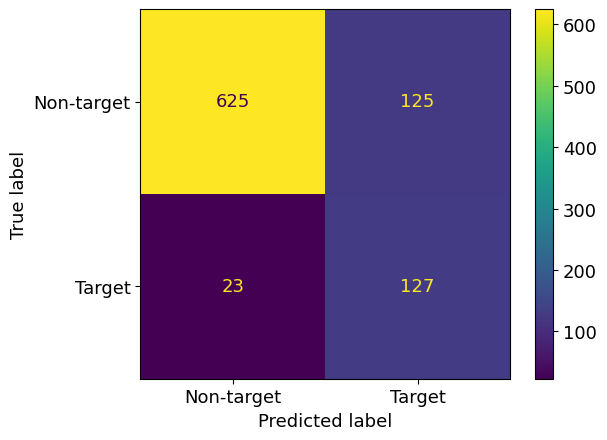

In [51]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

confus = get_confusion_mat(res, y_train, n_nontarget, n_target, if_plot=True)

In [52]:
get_stats(confus)

[0.8355555555555556, 0.8466666666666667, 0.8333333333333334]

## Euclidean Mean

In [143]:
cent0 = euclidean_mean(train_nontarget_cov[1,:])
cent1 = euclidean_mean(train_target_cov[1,:])

res = mdm_riemann_classifier(cent0, cent1, x_train, y_train)

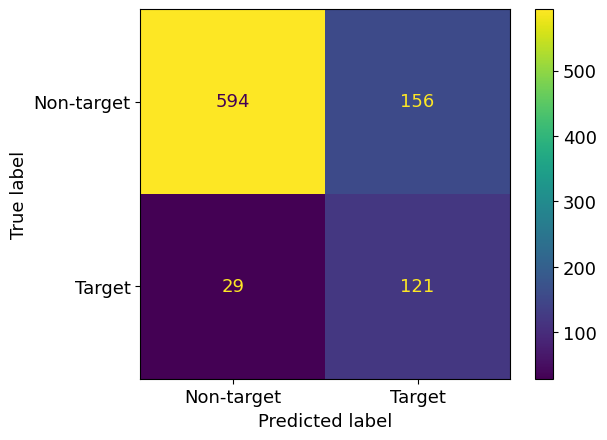

In [145]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

confus = get_confusion_mat(res, y_train, n_nontarget, n_target, if_plot=True)

In [55]:
get_stats(confus)

[0.7944444444444444, 0.8066666666666666, 0.792]

## Matrix Median

In [479]:
cent0 = matrix_median(train_nontarget_cov[1,:])
cent1 = matrix_median(train_target_cov[1,:])

res = mdm_riemann_classifier(cent0, cent1, x_train, y_train)

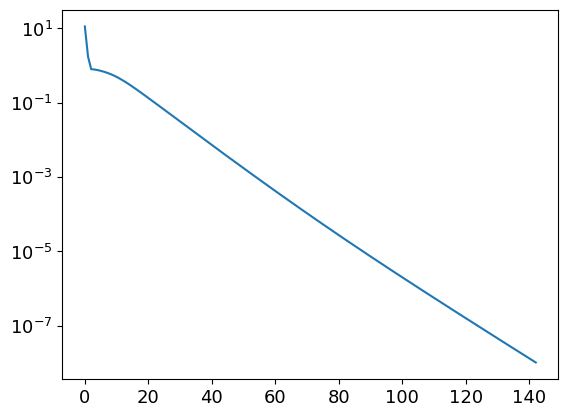

In [471]:
# previous convergence when testing - uncomment and add another output to test
plt.semilogy(test1)

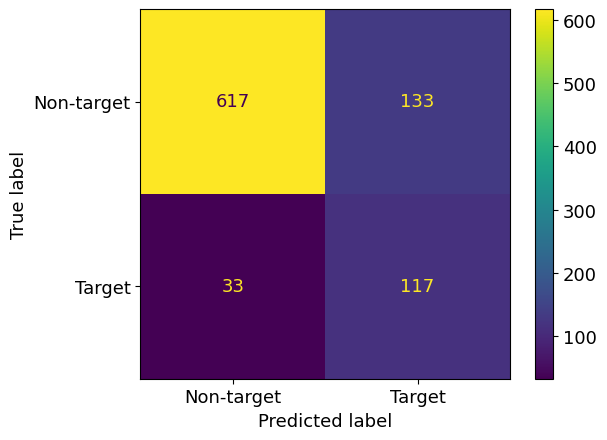

In [480]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

confus = get_confusion_mat(res, y_train, n_nontarget, n_target, if_plot=True)

In [481]:
get_stats(confus)

[0.8155555555555556, 0.78, 0.8226666666666667]

## Riemannian Median

In [561]:
cent0 = riemannian_median(train_nontarget_cov[1,:])
cent1 = riemannian_median(train_target_cov[1,:])

res = mdm_riemann_classifier(cent0, cent1, x_train, y_train)

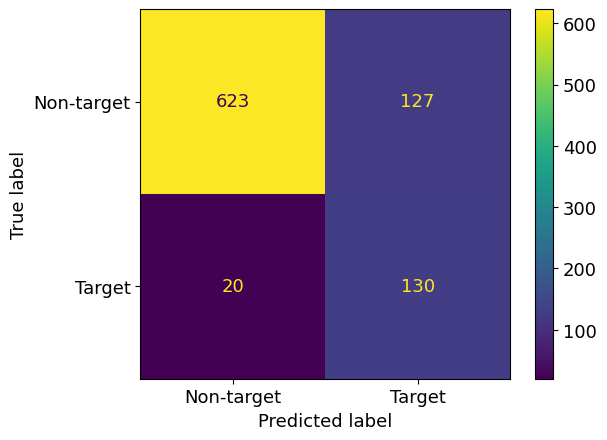

In [562]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

confus = get_confusion_mat(res, y_train, n_nontarget, n_target, if_plot=True)

In [563]:
get_stats(confus)

[0.8366666666666667, 0.8666666666666667, 0.8306666666666667]

## Huber Centroid

In [730]:
cent0 = huber_centroid(train_nontarget_cov[1,:])
cent1 = huber_centroid(train_target_cov[1,:])

res = mdm_riemann_classifier(cent0, cent1, x_train, y_train)

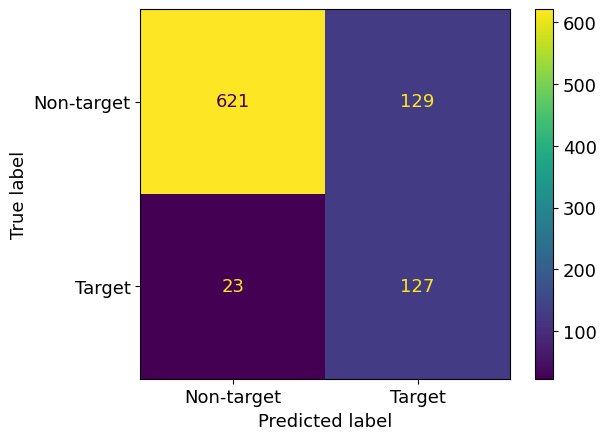

In [731]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

confus = get_confusion_mat(res, y_train, n_nontarget, n_target, if_plot=True)

In [732]:
get_stats(confus)

[0.8311111111111111, 0.8466666666666667, 0.828]

# Transfer Learning

In [ ]:
# from: https://ieeexplore.ieee.org/document/8013808
# input is the data from both classes from two sessions/players/tasks/etc 
# below is helper function

def transform_mat(mat, ref):
    ref_invsqrt = invsqrtm(ref)
    return ref_invsqrt @ mat @ ref_invsqrt


def transfer_learn(nontarget0, target0, nontarget1, target1, cent_type):
    if cent_type == 'riemann_mean':
        ref_0 = riemannian_mean(nontarget0)
        ref_1 = riemannian_mean(nontarget1)
    elif cent_type == 'euclid_mean':
        ref_0 = euclidean_mean(nontarget0)
        ref_1 = euclidean_mean(nontarget1)
    elif cent_type == 'mat_med':
        ref_0 = matrix_median(nontarget0)
        ref_1 = matrix_median(nontarget1)
    elif cent_type == 'riemann_med':
        ref_0 = riemannian_median(nontarget0)
        ref_1 = riemannian_median(nontarget1)
    elif cent_type == 'huber':
        ref_0 = huber_centroid(nontarget0)
        ref_1 = huber_centroid(nontarget1)
    else:
        raise ValueError("No such center type. Options are: riemann_mean, euclid_mean, mat_med, riemann_med, and huber")

    new_nontarget0 = transform_mat(nontarget0, ref_0)
    new_target0 = transform_mat(target0, ref_0)
    new_nontarget1 = transform_mat(nontarget1, ref_1)
    new_target1 = transform_mat(target1, ref_1)

    return new_nontarget0, new_target0, new_nontarget1, new_target1

## Riemannian Mean

Pre transfer learning

In [194]:
cent0 = riemannian_mean(train_nontarget_cov[1,:]) 
cent1 = riemannian_mean(train_target_cov[1,:])

x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

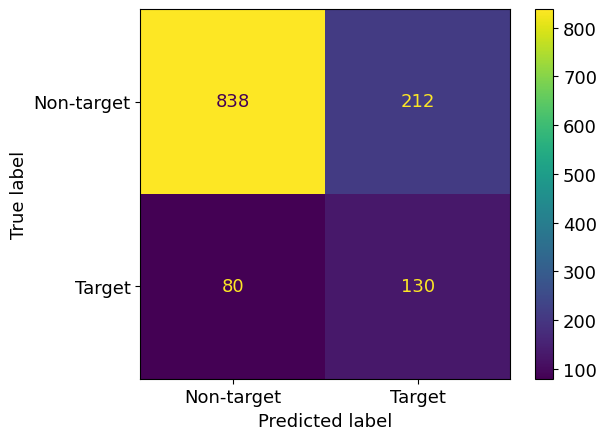

In [195]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [196]:
get_stats(confus)

[0.7682539682539683, 0.6190476190476191, 0.7980952380952381]

Post transfer learning

In [197]:
new_train_nontarget, new_train_target, new_test_nontarget, new_test_target = transfer_learn(train_nontarget_cov[1,:], train_target_cov[1,:], test_nontarget_cov[1], test_target_cov[1], cent_type='riemann_mean')

In [198]:
cent0 = riemannian_mean(new_train_nontarget)
cent1 = riemannian_mean(new_train_target)

x_test = np.vstack([new_test_nontarget, new_test_target])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

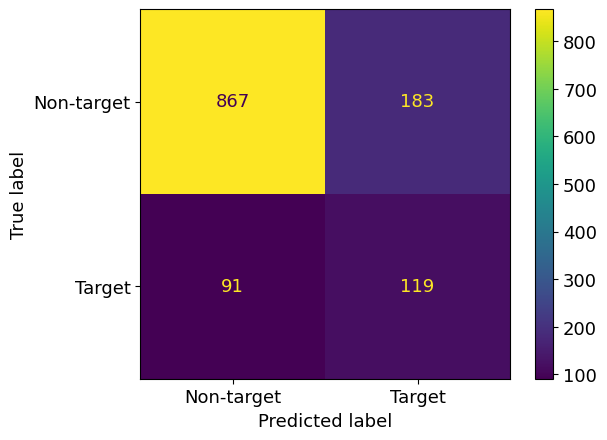

In [ ]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [200]:
get_stats(confus)

[0.7825396825396825, 0.5666666666666667, 0.8257142857142857]

## Euclidean Mean

Pre transfer learning

In [201]:
cent0 = euclidean_mean(train_nontarget_cov[1,:])
cent1 = euclidean_mean(train_target_cov[1,:])

x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

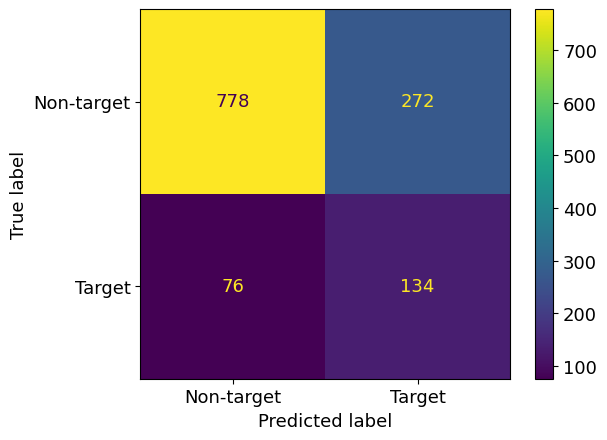

In [202]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [203]:
get_stats(confus)

[0.7238095238095238, 0.638095238095238, 0.7409523809523809]

Post transfer learning

In [204]:
new_train_nontarget, new_train_target, new_test_nontarget, new_test_target = transfer_learn(train_nontarget_cov[1,:], train_target_cov[1,:], test_nontarget_cov[1], test_target_cov[1], cent_type='euclid_mean')

In [205]:
cent0 = euclidean_mean(new_train_nontarget)
cent1 = euclidean_mean(new_train_target)

x_test = np.vstack([new_test_nontarget, new_test_target])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

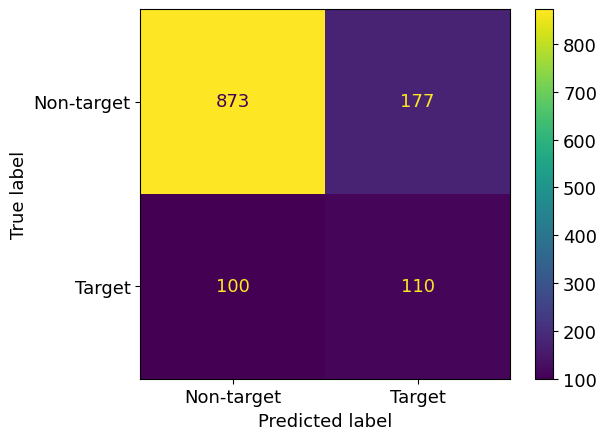

In [206]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [207]:
get_stats(confus)

[0.7801587301587302, 0.5238095238095238, 0.8314285714285714]

## Matrix Median

Pre transfer learning

In [483]:
cent0 = matrix_median(train_nontarget_cov[1,:]) 
cent1 = matrix_median(train_target_cov[1,:])

x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

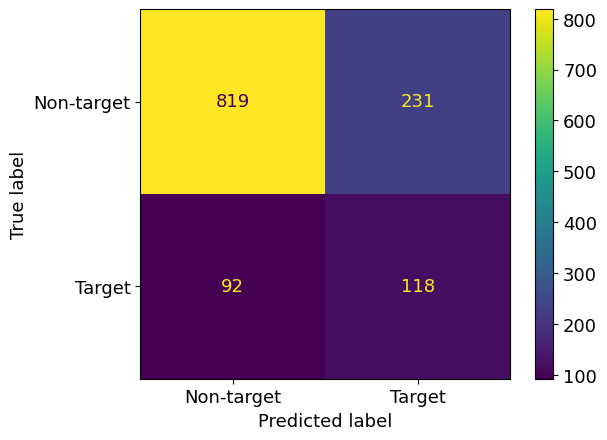

In [484]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [485]:
get_stats(confus)

[0.7436507936507937, 0.5619047619047619, 0.78]

Post transfer learning

In [489]:
new_train_nontarget, new_train_target, new_test_nontarget, new_test_target = transfer_learn(train_nontarget_cov[1,:], train_target_cov[1,:], test_nontarget_cov[1], test_target_cov[1], cent_type='mat_med')

In [490]:
cent0 = matrix_median(new_train_nontarget)
cent1 = matrix_median(new_train_target)

x_test = np.vstack([new_test_nontarget, new_test_target])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

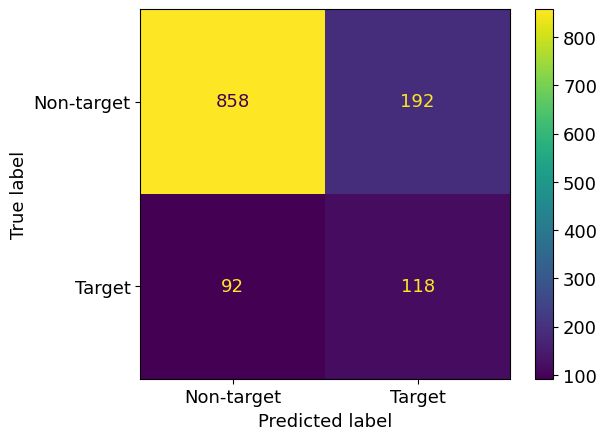

In [491]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [492]:
get_stats(confus)

[0.7746031746031746, 0.5619047619047619, 0.8171428571428572]

## Riemannian Median

Pre transfer learning

In [564]:
cent0 = riemannian_median(train_nontarget_cov[1,:]) 
cent1 = riemannian_median(train_target_cov[1,:])

x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

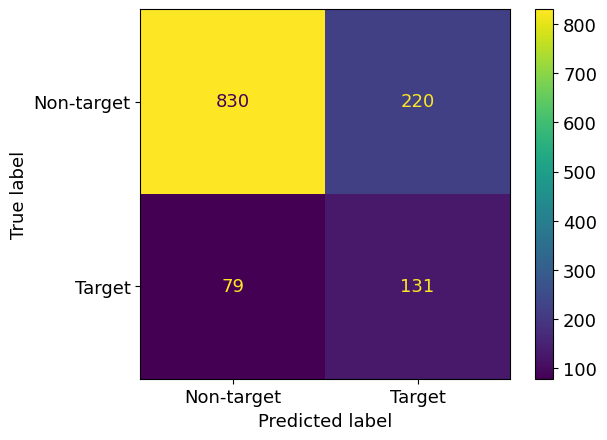

In [565]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [566]:
get_stats(confus)

[0.7626984126984127, 0.6238095238095238, 0.7904761904761904]

Post transfer learning

In [567]:
new_train_nontarget, new_train_target, new_test_nontarget, new_test_target = transfer_learn(train_nontarget_cov[1,:], train_target_cov[1,:], test_nontarget_cov[1], test_target_cov[1], cent_type='riemann_mean')

In [571]:
cent0 = riemannian_median(new_train_nontarget)
cent1 = riemannian_median(new_train_target)

x_test = np.vstack([new_test_nontarget, new_test_target])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

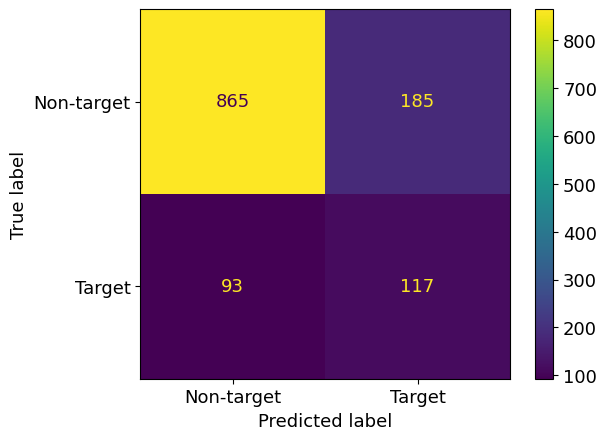

In [572]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [573]:
get_stats(confus)

[0.7793650793650794, 0.5571428571428572, 0.8238095238095238]

## Huber Centroid

Pre transfer learning

In [696]:
cent0 = huber_centroid(train_nontarget_cov[1,:]) 
cent1 = huber_centroid(train_target_cov[1,:])

x_test = np.vstack([test_nontarget_cov[1], test_target_cov[1]])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

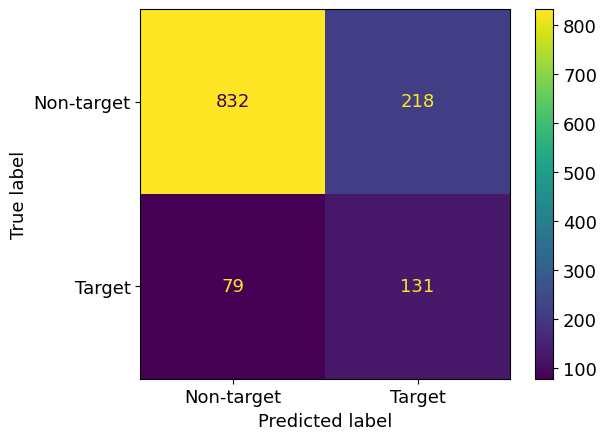

In [697]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [698]:
get_stats(confus)

[0.7642857142857142, 0.6238095238095238, 0.7923809523809524]

Post transfer learning

In [699]:
new_train_nontarget, new_train_target, new_test_nontarget, new_test_target = transfer_learn(train_nontarget_cov[1,:], train_target_cov[1,:], test_nontarget_cov[1], test_target_cov[1], cent_type='riemann_mean')

In [700]:
cent0 = huber_centroid(new_train_nontarget)
cent1 = huber_centroid(new_train_target)

x_test = np.vstack([new_test_nontarget, new_test_target])
res = mdm_riemann_classifier(cent0, cent1, x_test, y_test)

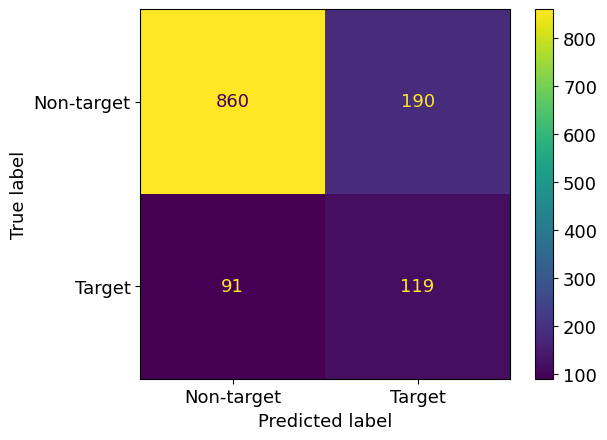

In [701]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

confus = get_confusion_mat(res, y_test, n_nontarget, n_target, if_plot=True)

In [702]:
get_stats(confus)

[0.776984126984127, 0.5666666666666667, 0.819047619047619]

# Chance Performance

In [493]:
def chance_perf(n_nontarget, n_target):
    n_trials = n_nontarget + n_target
    prob_nontarget = n_nontarget / n_trials
    prob_target = n_target / n_trials

    n, p = 1, prob_target
    chance_pred = np.random.binomial(n, p, n_trials)

    return chance_pred

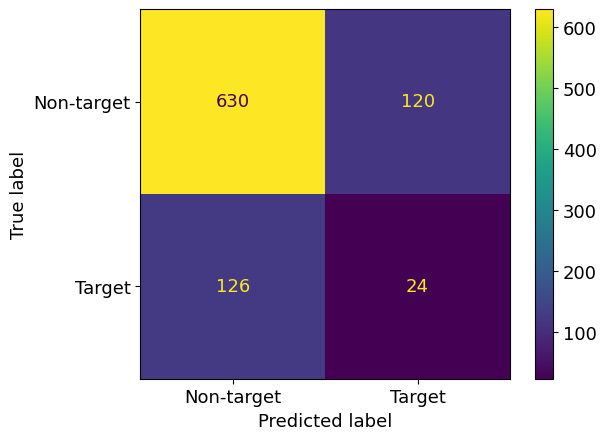

In [494]:
n_nontarget = len(train_nontarget_cov[1])
n_target = len(train_target_cov[1])

train_chance = chance_perf(n_nontarget, n_target)
confus = get_confusion_mat(train_chance, y_train, n_nontarget, n_target, if_plot=True)

In [495]:
get_stats(confus)

[0.7266666666666667, 0.16, 0.84]

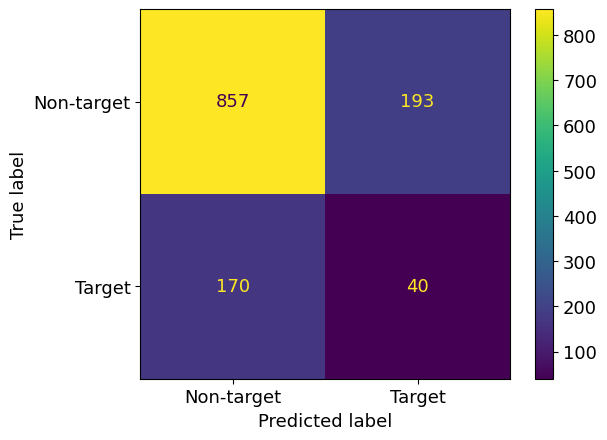

In [496]:
n_nontarget = len(test_nontarget_cov[1])
n_target = len(test_target_cov[1])

test_chance = chance_perf(n_nontarget, n_target)
confus = get_confusion_mat(test_chance, y_test, n_nontarget, n_target, if_plot=True)

In [497]:
get_stats(confus)

[0.7119047619047619, 0.19047619047619047, 0.8161904761904762]

# Quick Plot for Midterm Report

In [703]:
# Acc / Sens / Spec
# Training Data
riemann_perf = [0.8355555555555556, 0.8466666666666667, 0.8333333333333334]
euclid_perf =[0.7944444444444444, 0.8066666666666666, 0.792]
mat_med_perf = [0.8155555555555556, 0.78, 0.8226666666666667]
riemann_med_perf = [0.8366666666666667, 0.8666666666666667, 0.8306666666666667]
huber_perf = [0.8311111111111111, 0.8466666666666667, 0.828]
chance_perf = [0.7266666666666667, 0.16, 0.84]

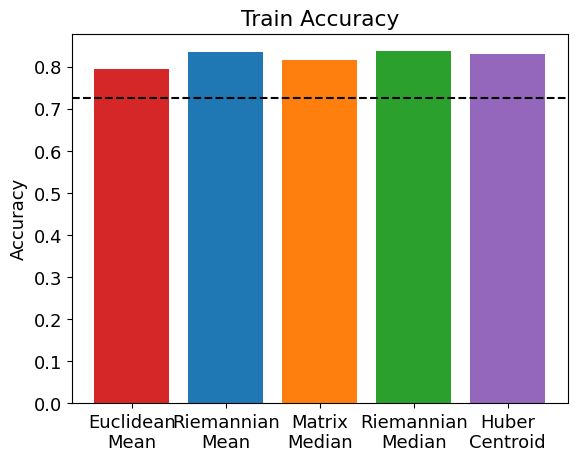

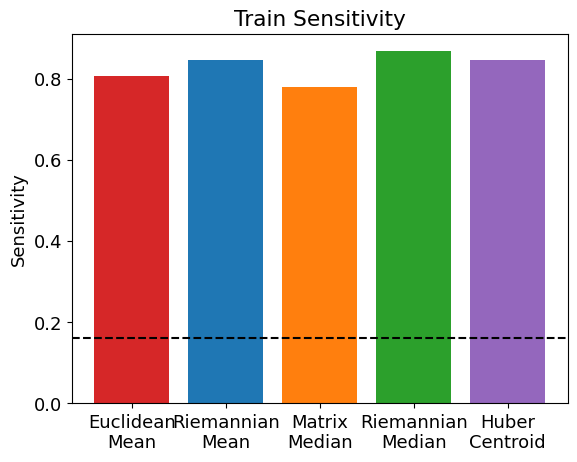

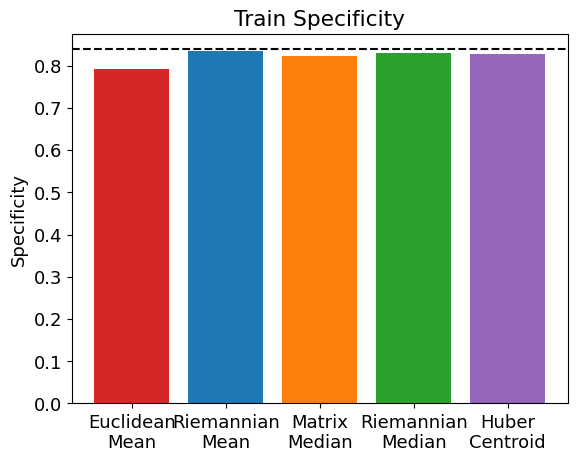

In [705]:
metrics = ["Accuracy", "Sensitivity", "Specificity"]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
for idx, met_type in enumerate(metrics):
    plt.bar(["Euclidean\nMean", "Riemannian\nMean", "Matrix\nMedian", "Riemannian\nMedian", "Huber\nCentroid"], [euclid_perf[idx], riemann_perf[idx], mat_med_perf[idx], riemann_med_perf[idx], huber_perf[idx]], color=bar_colors)
    plt.axhline(y=chance_perf[idx], color='black', linestyle='--')
    # plt.ylim([0.5, 0.9])
    plt.ylabel(metrics[idx])
    plt.title("Train " + metrics[idx])
    
    plt.savefig("Train " + metrics[idx] + ".png")
    plt.show()

In [706]:
# Pre / Post, Acc / Sens / Spec
# Testing Data
riemann_perf = [[0.7682539682539683, 0.6190476190476191, 0.7980952380952381],
                [0.7825396825396825, 0.5666666666666667, 0.8257142857142857]]
euclid_perf = [[0.7238095238095238, 0.638095238095238, 0.7409523809523809], 
              [0.7801587301587302, 0.5238095238095238, 0.8314285714285714]]
mat_med_perf = [[0.7436507936507937, 0.5619047619047619, 0.78],
                [0.7746031746031746, 0.5619047619047619, 0.8171428571428572]]
riemann_med_perf = [[0.7626984126984127, 0.6238095238095238, 0.7904761904761904],
                    [0.7793650793650794, 0.5571428571428572, 0.8238095238095238]]
huber_perf = [[0.7642857142857142, 0.6238095238095238, 0.7923809523809524],
              [0.776984126984127, 0.5666666666666667, 0.819047619047619]]
chance_perf = [0.7119047619047619, 0.19047619047619047, 0.8161904761904762]

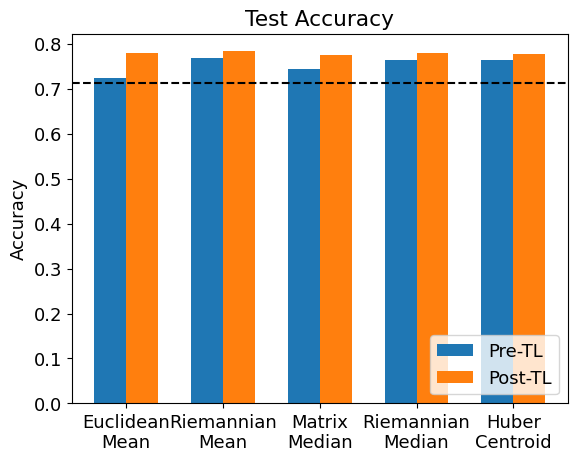

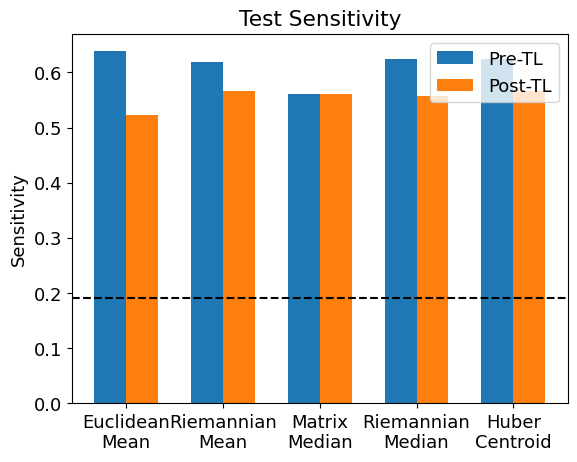

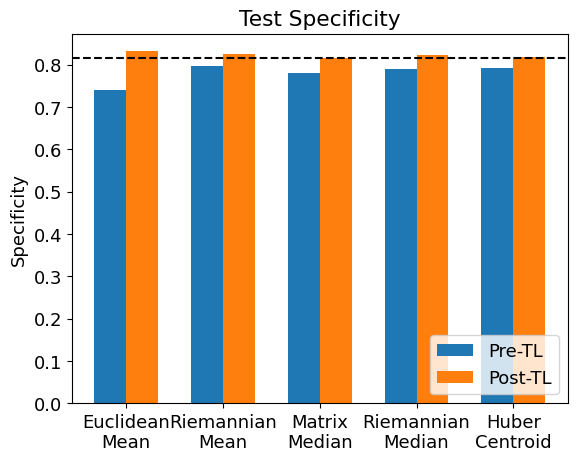

In [709]:
# based on: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
metrics = ["Accuracy", "Sensitivity", "Specificity"]
cent_types = ["Euclidean\nMean", "Riemannian\nMean", "Matrix\nMedian", "Riemannian\nMedian", "Huber\nCentroid"]

for idx, met_type in enumerate(metrics):
    x = np.arange(len(cent_types))
    width = 0.33
    multiplier = 0.5

    fig, ax = plt.subplots()
    meas_types = ["Pre-TL", "Post-TL"]
    for meas_idx, meas in enumerate(meas_types):
        offset = width * multiplier
        rects = ax.bar(x + offset, [euclid_perf[meas_idx][idx], riemann_perf[meas_idx][idx], mat_med_perf[meas_idx][idx], riemann_med_perf[meas_idx][idx], huber_perf[meas_idx][idx]], width, label=meas)
        multiplier += 1

    ax.axhline(y=chance_perf[idx], color='black', linestyle='--')
    ax.set_xticks(x + width, cent_types)
    ax.set_ylabel(metrics[idx])
    if met_type == "Sensitivity":
        ax.legend(loc='upper right')
    else:
        ax.legend(loc='lower right')
    ax.set_title("Test " + metrics[idx])

    plt.savefig("Test " + metrics[idx] + ".png")
    plt.show()